# Age regression
* data source: https://susanqq.github.io/UTKFace/

In [1]:
import glob
import pandas as pd
import numpy as np
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import os
from sklearn.model_selection import train_test_split

## Loading data 

In [2]:
allImages = pd.DataFrame(glob.glob("UTKFace/*.jpg"), columns= ["Path"])
allImages

,Path
0,UTKFace\100_0_0_20170112213500903.jpg
1,UTKFace\100_0_0_20170112215240346.jpg
2,UTKFace\100_1_0_20170110183726390.jpg
3,UTKFace\100_1_0_20170112213001988.jpg
4,UTKFace\100_1_0_20170112213303693.jpg
...,...
23703,UTKFace\9_1_3_20161220222856346.jpg
23704,UTKFace\9_1_3_20170104222949455.jpg
23705,UTKFace\9_1_4_20170103200637399.jpg
23706,UTKFace\9_1_4_20170103200814791.jpg


### Extraxt data from file names

In [3]:
allImages["Age"] = allImages["Path"].apply(
    lambda x: x.split('\\')[1].split("_")[0]
).astype(int)

allImages["Gender"] = allImages["Path"].apply(
    lambda x: x.split('\\')[1].split("_")[1]
).astype(int)
allImages["Gender"].replace(
    [0, 1],
    ["Male", "Female"],
    inplace=True
)

allImages["Race"] = allImages["Path"].apply(
    lambda x: x.split('\\')[1].split("_")[2]
)
allImages

,Path,Age,Gender,Race
0,UTKFace\100_0_0_20170112213500903.jpg,100,Male,0
1,UTKFace\100_0_0_20170112215240346.jpg,100,Male,0
2,UTKFace\100_1_0_20170110183726390.jpg,100,Female,0
3,UTKFace\100_1_0_20170112213001988.jpg,100,Female,0
4,UTKFace\100_1_0_20170112213303693.jpg,100,Female,0
...,...,...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg,9,Female,3
23704,UTKFace\9_1_3_20170104222949455.jpg,9,Female,3
23705,UTKFace\9_1_4_20170103200637399.jpg,9,Female,4
23706,UTKFace\9_1_4_20170103200814791.jpg,9,Female,4


In [4]:
allImages[~allImages["Race"].isin(['0','1','2','3','4'])]

,Path,Age,Gender,Race
15015,UTKFace\39_1_20170116174525125.jpg,39,Female,20170116174525125.jpg
20793,UTKFace\61_1_20170109142408075.jpg,61,Female,20170109142408075.jpg
20794,UTKFace\61_1_20170109150557335.jpg,61,Female,20170109150557335.jpg


(Found out there are some incorrect names - lets drop them)

In [5]:
allImages = allImages[allImages["Race"].isin(['0','1','2','3','4'])]
allImages[~allImages["Race"].isin(['0','1','2','3','4'])]

,Path,Age,Gender,Race


Now we should be able to change integers to race names

In [6]:
allImages["Race"] = allImages["Race"].astype(int).replace(
    range(0,5),
    ['White', 'Black', 'Asian', 'Indian', 'Others']
)
allImages

C:\Users\stani\AppData\Local\Temp\ipykernel_14292\4096037970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allImages["Race"] = allImages["Race"].astype(int).replace(


,Path,Age,Gender,Race
0,UTKFace\100_0_0_20170112213500903.jpg,100,Male,White
1,UTKFace\100_0_0_20170112215240346.jpg,100,Male,White
2,UTKFace\100_1_0_20170110183726390.jpg,100,Female,White
3,UTKFace\100_1_0_20170112213001988.jpg,100,Female,White
4,UTKFace\100_1_0_20170112213303693.jpg,100,Female,White
...,...,...,...,...
23703,UTKFace\9_1_3_20161220222856346.jpg,9,Female,Indian
23704,UTKFace\9_1_3_20170104222949455.jpg,9,Female,Indian
23705,UTKFace\9_1_4_20170103200637399.jpg,9,Female,Others
23706,UTKFace\9_1_4_20170103200814791.jpg,9,Female,Others


### Age groups

In [7]:
def group(x):
    if x<=3:
        return "1 - 3"
    elif x<=9:
        return "4 - 10"
    elif x<=15:
        return "11 - 15"
    elif x<=20:
        return "16 - 20"
    elif x<=25:
        return "21 - 25"
    elif x<=30:
        return "26 - 30"
    elif x<=40:
        return "31 - 40"
    elif x<=50:
        return "41 - 50"
    elif x<=60:
        return "51 - 60"
    else:
        return "61 -"

In [8]:
allImages["AgeGroup"] = allImages["Age"].apply(lambda x: group(x))

C:\Users\stani\AppData\Local\Temp\ipykernel_14292\2291520857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allImages["AgeGroup"] = allImages["Age"].apply(lambda x: group(x))


In [ ]:
allImages

## Getting used to our data

In [9]:
def view_image(row, category):
    img = mpimg.imread(list(row["Path"])[0])
    plt.imshow(img)
    plt.title(list(row[category])[0])
    plt.axis("off")
    return img

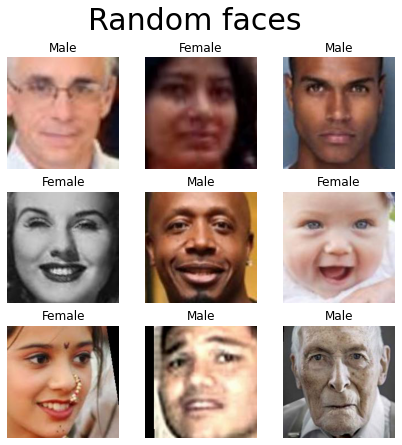

In [10]:
sample = allImages.sample(n=9)
plt.figure(figsize=(7,7))
plt.suptitle("Random faces", fontsize=30)
for x in range(9):
    plt.subplot(3,3,x+1)
    img = view_image(sample.iloc[[x]], "Gender") # change "Gender" to "AgeGroup" or "Race"
plt.show()

## Preraping for modeling

Choose "Gender" "AgeGroup" or "Race"

In [11]:
category = "Gender"

When taking into account race or gender, we can omit the data of people under 3 years of age because they may hinder the training of the model

In [15]:
if category != "AgeGroup":
    allImages = allImages[allImages["Age"] > 3]

In [14]:
if os.path.exists(category):
    shutil.rmtree(category)

#### Divide data between folders

In [17]:
dirs = [category+"/train", category+"/test"]
labels = allImages[category].drop_duplicates()
for dir in dirs:
    for label in labels:
        myPath = os.path.join(dir, label)
        if not os.path.exists(myPath):
            os.makedirs(myPath)

In [18]:
trainImages, testImages = train_test_split(allImages, random_state=23, stratify=allImages[category])

In [19]:
trainImages.shape, testImages.shape

((16358, 5), (5453, 5))

In [20]:
threshold = trainImages.groupby(category).count().min().min()
threshold

7792

Train Images

In [21]:
for label in labels:
    labelSet = trainImages[trainImages[category] == label]
    iterable = labelSet.T.iteritems()
    for i, (date, img) in enumerate(iterable):
        if i == threshold:
            break
        src = img["Path"]
        dst = category + "/train/" + img[category] + "/" + str(i) + ".jpg"
        shutil.copy(src=src, dst=dst)
        

Test images

In [22]:
iterable = testImages.T.iteritems()
for i, (date, img) in enumerate(iterable):
    src = img["Path"]
    dst = category + "/test/" + img[category] + "/" + str(i) + ".jpg"
    shutil.copy(src=src, dst=dst)